In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory      
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fakenews-poland-clean-topics/embeddings_pl_herbert.csv
/kaggle/input/fakenews-poland-clean-topics/topics.csv
/kaggle/input/fakenews-poland-clean-topics/fake_news_features_combined.csv


In [2]:
!pip install sentence-transformers
!pip install transformers
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 927.3 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=9f51b1f3f8e22cbeca8aa2d0913fc5fcb7cc179148f189dc972969a24f92b26b
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [3]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

from sklearn.base import clone as sklearn_clone

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel, HerbertTokenizer, BatchEncoding

import gc

In [4]:
torch.manual_seed(111)
np.random.seed(111)
random.seed(111)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()
    
device.type

'cuda'

## Get HerBERT

In [5]:
# tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-large-cased")
model_herbert = AutoModel.from_pretrained("allegro/herbert-large-cased")

Downloading:   0%|          | 0.00/664 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Some weights of the model checkpoint at allegro/herbert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.sso.sso_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Get data

In [6]:
df_topics = pd.read_csv('../input/fakenews-poland-clean-topics/topics.csv', index_col=0)

In [7]:
df = pd.read_csv('../input/fakenews-poland-clean-topics/fake_news_features_combined.csv', sep=';')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

df = df.copy()[['assestment', 'text_clean']][df.index.isin(df_topics.index)].reset_index(drop=True)

In [8]:
embeddings_table = pd.read_csv('../input/fakenews-poland-clean-topics/embeddings_pl_herbert.csv', sep=",", header=None).values

In [9]:
class FakeNews(Dataset):
    def __init__(self, emb_dt, y_dt, index_to_use):
        self.emb = emb_dt[index_to_use]
        
        self.labels = y_dt[index_to_use]
        
        self.index = np.arange(index_to_use.shape[0])
        
    def __len__(self):
        return len(self.emb)
    
    def __getitem__(self, item):
        anchor_label = self.labels[item]

        positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

        positive_item = random.choice(positive_list)
        
        negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
        negative_item = random.choice(negative_list)
        
        anchor_claim = self.emb[item].astype(np.float32)
        positive_claim = self.emb[positive_item].astype(np.float32)
        negative_claim = self.emb[negative_item].astype(np.float32)

        anchor_label = anchor_label.astype(np.float32)

        return anchor_claim, positive_claim, negative_claim, anchor_label

## Kfold

In [10]:
cv_fold = []
cv_fold_i = []

for i in df_topics['topic'].unique().reshape(10,-1):
    train_cv = df_topics.index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
    
    train_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])
    cv_fold_i.append( [train_cv_i, test_cv_i])

In [11]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_topics)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(df_topics):
    train_cv = df_topics.iloc[ train_index, : ].index.values
    test_cv = df_topics.iloc[ test_index, : ].index.values

    train_cv_i= df_topics.reset_index().iloc[ train_index, : ].index.values
    test_cv_i = df_topics.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, test_cv_i])

## Train

In [12]:
embedding_dims = 128
batch_size = 128
epochs = 30

## TripletLoss

In [15]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

## Define Net

In [16]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, emb_dim)
        )
        
    def forward(self, x):
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

## Some testing one one kfold

In [13]:
train_index, test_index = cv_fold_i[0]

In [14]:
train_ds = FakeNews(embeddings_table, df['assestment'].values, train_index)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

test_ds = FakeNews(embeddings_table, df['assestment'].values, test_index)
test_loader = DataLoader(test_ds, batch_size=batch_size//2, shuffle=False, num_workers=2)

In [18]:
model = Network(embedding_dims)
model = torch.nn.DataParallel(model)
# model = torch.jit.script(model).to(device)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = torch.jit.script(TripletLoss())
criterion = TripletLoss()

## Training loop

In [19]:
model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_claim = anchor_claim.to(device)
        positive_claim = positive_claim.to(device)
        negative_claim = negative_claim.to(device)

        optimizer.zero_grad()
        anchor_out = model(anchor_claim)
        positive_out = model(positive_claim)
        negative_out = model(negative_claim)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
        
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1/30 - Loss: 3.1865


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 2/30 - Loss: 1.5242


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 3/30 - Loss: 1.2293


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 4/30 - Loss: 1.1041


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 5/30 - Loss: 1.0666


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 6/30 - Loss: 0.9873


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 7/30 - Loss: 1.0360


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 8/30 - Loss: 1.0169


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 9/30 - Loss: 1.0143


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 10/30 - Loss: 0.9856


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 11/30 - Loss: 0.9923


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 12/30 - Loss: 0.9857


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 13/30 - Loss: 0.9344


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 14/30 - Loss: 0.9259


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 15/30 - Loss: 0.9644


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 16/30 - Loss: 0.9323


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 17/30 - Loss: 0.9136


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 18/30 - Loss: 0.8723


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 19/30 - Loss: 0.8147


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 20/30 - Loss: 0.8009


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 21/30 - Loss: 0.7598


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 22/30 - Loss: 0.7464


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 23/30 - Loss: 0.7451


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 24/30 - Loss: 0.7009


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 25/30 - Loss: 0.6756


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 26/30 - Loss: 0.6592


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 27/30 - Loss: 0.6250


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 28/30 - Loss: 0.6020


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 29/30 - Loss: 0.5895


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 30/30 - Loss: 0.5453


In [27]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for claim, _, _, label in tqdm(train_loader):
        anchor_claim = claim.to(device)
        
        train_results.append(model(anchor_claim).cpu().numpy())
        labels.append(label)
        
#         del anchor_claim 
#         gc.collect()
#         torch.cuda.empty_cache()

train_results = np.concatenate(train_results) 
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/46 [00:00<?, ?it/s]

(5886, 128)

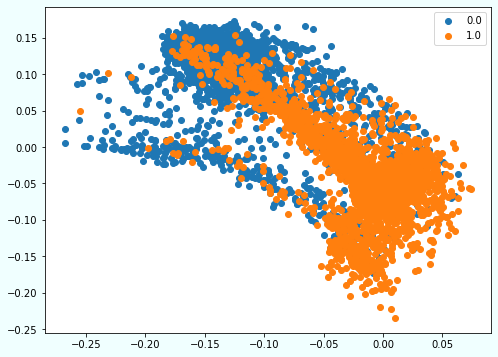

In [28]:
plt.figure(figsize=(8, 6), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

In [29]:
test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for claim, _, _, label in tqdm(train_loader):
        anchor_claim = claim.to(device)
        
        test_results.append(model(anchor_claim).cpu().numpy())
        test_labels.append(label)
        
#         del anchor_claim 
#         gc.collect()
#         torch.cuda.empty_cache()

test_results = np.concatenate(test_results)
test_labels = np.concatenate(test_labels)
test_results.shape

  0%|          | 0/46 [00:00<?, ?it/s]

(5886, 128)

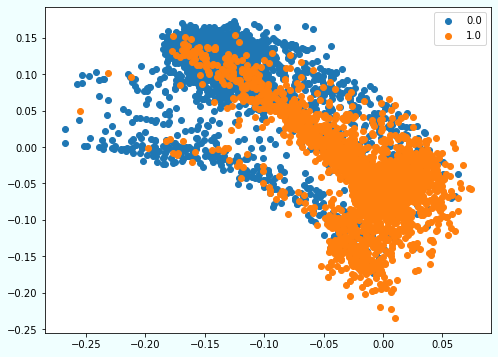

In [30]:
plt.figure(figsize=(8, 6), facecolor="azure")
for label in np.unique(test_labels):
    tmp = test_results[test_labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

In [31]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

In [32]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}


y_train_t = labels
X_train_t = train_results
y_test_t = test_labels
X_test_t = test_results

clf_lr_1.fit(X_train_t, y_train_t)

y_pred = clf_lr_1.predict(X_test_t)

results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
results['test_f1'].append( f1_score(y_test_t, y_pred) ) 

metrics = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

In [33]:
metrics

{'Accuracy': array([0.89772341]), 'F1 Score': array([0.89371469])}

# Test using CV

In [20]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

for j, (train_index, test_index) in enumerate(cv_fold_i):
    train_ds = FakeNews(embeddings_table, df['assestment'].values, train_index)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

    test_ds = FakeNews(embeddings_table, df['assestment'].values, test_index)
    test_loader = DataLoader(test_ds, batch_size=batch_size//2, shuffle=False, num_workers=2)

    
    model = Network(100)
    model = torch.jit.script(model).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.jit.script(TripletLoss())


    model.train()
    for epoch in tqdm(range(epochs), desc=f"Epochs {j}"):
        running_loss = []
        for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)

            optimizer.zero_grad()
            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.cpu().detach().numpy())

    
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            anchor_claim = claim.to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)


    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            anchor_claim = claim.to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)


    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    

Epochs 0:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs 1:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs 2:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f03b5e60d40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f03b5e60d40>  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

      File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
self._shutdown_workers()    
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():

AssertionError  File "/opt/conda/lib/python3.7/multiprocessing

Epochs 3:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs 4:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs 5:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs 6:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs 7:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs 8:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs 9:   0%|          | 0/30 [00:00<?, ?it/s]

triplet loss lr C1 Accuracy 0.920+-0.026 F1 Score 0.917+-0.025  0.920+-0.026 | 0.917+-0.025


In [17]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

for train_index, test_index in cv_Kfold_i:
    train_ds = FakeNews(embeddings_table, df['assestment'].values, train_index)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

    test_ds = FakeNews(embeddings_table, df['assestment'].values, test_index)
    test_loader = DataLoader(test_ds, batch_size=batch_size//2, shuffle=False, num_workers=2)

    
    model = Network(100)
    model = torch.jit.script(model).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.jit.script(TripletLoss())


    model.train()
    for epoch in tqdm(range(epochs), desc="Epochs"):
        running_loss = []
        for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)

            optimizer.zero_grad()
            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.cpu().detach().numpy())

    
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            anchor_claim = claim.to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)


    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            anchor_claim = claim.to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)


    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

triplet loss lr C1 Accuracy 0.932+-0.008 F1 Score 0.929+-0.009  0.932+-0.008 | 0.929+-0.009
